In [19]:
import os

from scipy import stats
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import yaml
try:
    from yaml import CLoader as Loader
except ImportErorr:
    from yaml import Loader

In [20]:
# Set plot size
factor = 1.2
default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = default_dpi*factor

In [21]:
def load_data(cfg, datafiles):
    """Loads csv data files and converts measurements to SI units using the defined config
    
    Parameters
    ----------
    cfg : dict
        Board configuration
    datafiles : list
        List of data files paths
        
    Returns
    -------
    pd.DataFrame
        Concatenated dataframe from all datafiles
    """
    
    df_list = []
    for d in datafiles:
        df = pd.read_csv(d)
        df_list.append(df)
    
    data = pd.concat(df_list, ignore_index=True)
    data  = df.set_index("V")
    
    data["I_in"] = data["I_in"] * 1e6
    data["I_meas"] = data["V_i"] / cfg["r_sense"] / cfg["gain"] * 1e6
    data["V_meas"] = data["V_2x"] / 2.
    
    return data

In [22]:
# Config file name
cfg_path = "data/config.yaml"
# Data file name
datafiles = ["data/sps3.csv"]
# Evaluation data name
evalfiles = ["data/sps3_eval.csv"]

In [23]:
# Read config
with open(cfg_path, "r") as f:
    cfg = yaml.load(f, Loader=Loader)
cfg

{'date': datetime.date(2022, 8, 24),
 'r_load': 2200,
 'r_sense': 249,
 'gain': 10,
 'ref': 'unidirectional'}

In [24]:
data = load_data(cfg, datafiles)
data

,V_in,I_in,V_i,V_2x,I_meas,V_meas
V,,,,,,
0.10,0.100060,50.55657,0.106332,0.207019,42.703614,0.103510
0.10,0.100058,50.55559,0.106642,0.207003,42.828112,0.103501
0.10,0.100057,50.55650,0.106601,0.207023,42.811647,0.103512
0.10,0.100058,50.55659,0.106537,0.207027,42.785944,0.103513
0.10,0.100059,50.55670,0.106231,0.207068,42.663052,0.103534
...,...,...,...,...,...,...
0.95,0.949964,396.33190,0.962321,1.901955,386.474297,0.950978
0.95,0.949964,396.33170,0.962587,1.902048,386.581124,0.951024
0.95,0.949962,396.33080,0.962301,1.902028,386.466265,0.951014


In [25]:
eval_data = load_data(cfg, evalfiles)
eval_data

,V_in,I_in,V_i,V_2x,I_meas,V_meas
V,,,,,,
0.10,0.100067,50.19934,0.105872,0.205219,42.518876,0.102610
0.10,0.100066,50.19969,0.105945,0.205162,42.548193,0.102581
0.10,0.100066,50.20017,0.105929,0.205295,42.541767,0.102648
0.10,0.100067,50.19889,0.105804,0.205191,42.491566,0.102596
0.10,0.100064,50.19949,0.105711,0.205178,42.454217,0.102589
...,...,...,...,...,...,...
0.95,0.949958,395.90730,0.960670,1.900090,385.811245,0.950045
0.95,0.949960,395.90760,0.960916,1.900090,385.910040,0.950045
0.95,0.949960,395.90840,0.960887,1.900110,385.898394,0.950055


In [26]:
def plot_accuracy(x, y):
    """Plots a graph showing the accuracy of measurements y to ideal values x
    
    Parameters
    ----------
    x : Series
        True values
    y : Series
        Measured values
        
    Returns
    -------
    fig, ax
        Matplotlib figure, same format as plt.subplots
    """
    
    rel = y / x
    rel = rel.groupby("V").describe()
    
    fig, ax = plt.subplots()
    ax.errorbar(rel.index, rel["mean"], yerr=rel["std"])
    ax.axhline(y=1, linestyle=':', color='k', linewidth='3')
    ax.grid()
    
    return (fig, ax)

Text(0, 0.5, 'Relative Measurement (V/V)')

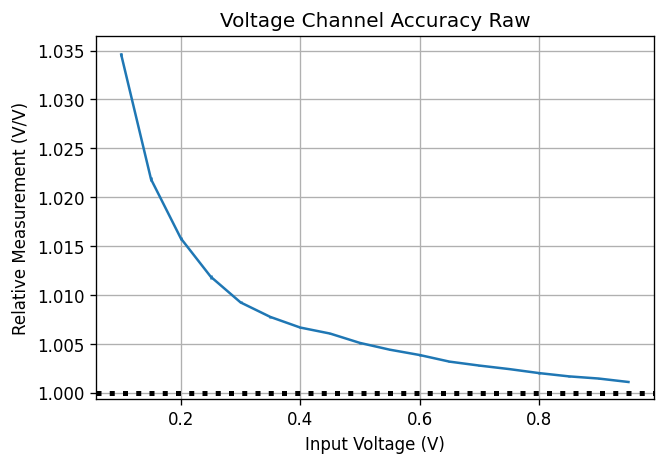

In [27]:
fig, ax = plot_accuracy(data["V_in"], data["V_meas"])

ax.set_title("Voltage Channel Accuracy Raw")
ax.set_xlabel("Input Voltage (V)")
ax.set_ylabel("Relative Measurement (V/V)")

Text(0, 0.5, 'Relative Measurement (A/A)')

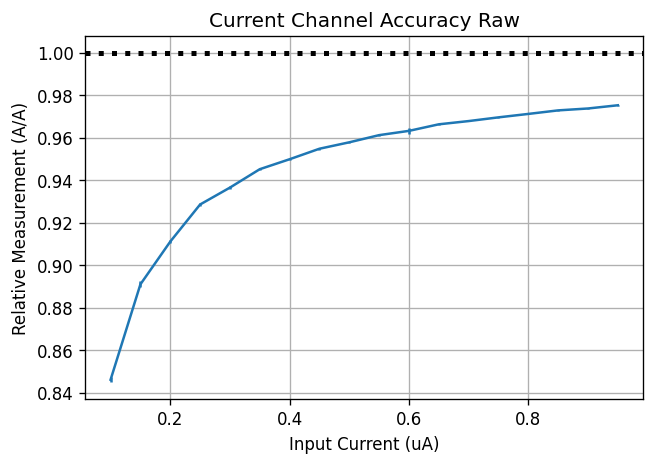

In [28]:
fig, ax = plot_accuracy(data["I_in"], data["I_meas"])

ax.set_title("Current Channel Accuracy Raw")
ax.set_xlabel("Input Current (uA)")
ax.set_ylabel("Relative Measurement (A/A)")

In [29]:
def calc_fit(x, y):
    """Calculates linear regression fit line given input x and output y.
    
    Parameters
    ----------
    x : Series
        input
    y : Series
        output
        
    Returns
    -------
    Series
        Fit line
    """
    
    linreg = stats.linregress(x, y)
    fit = linreg.intercept + x * linreg.slope
    return fit

In [30]:
data["V_fit"] = calc_fit(data["V_meas"], data["V_in"])
data["I_fit"] = calc_fit(data["I_meas"], data["I_in"])

Text(0, 0.5, 'Nonlinearity (V)')

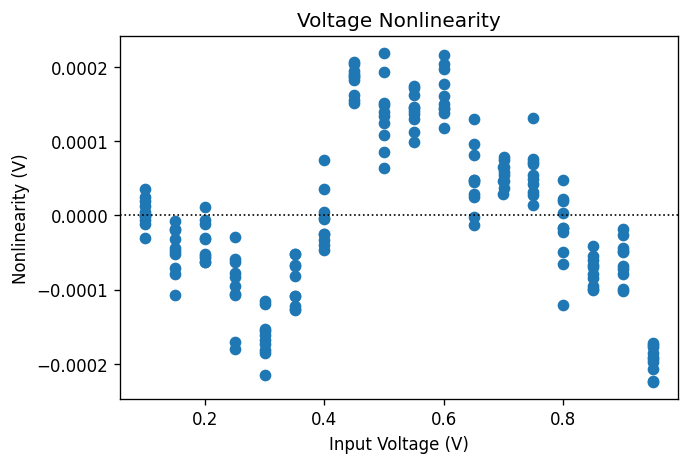

In [31]:
fig, ax = plt.subplots()
ax.scatter(data["V_in"], data["V_fit"] - data["V_in"])
ax.axhline(y=0, linestyle=':', color='k', linewidth='1')
ax.set_title("Voltage Nonlinearity")
ax.set_xlabel("Input Voltage (V)")
ax.set_ylabel("Nonlinearity (V)")

Text(0, 0.5, 'Nonlinearity (uA)')

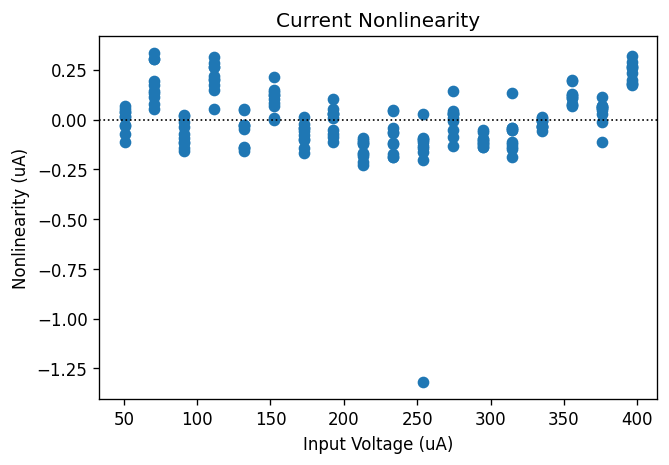

In [32]:
fig, ax = plt.subplots()
ax.scatter(data["I_in"], data["I_fit"] - data["I_in"])
ax.axhline(y=0, linestyle=':', color='k', linewidth='1')
ax.set_title("Current Nonlinearity")
ax.set_xlabel("Input Voltage (uA)")
ax.set_ylabel("Nonlinearity (uA)")

In [33]:
# Linear Regression
V_linreg = stats.linregress(data["V_meas"], data["V_in"])
I_linreg = stats.linregress(data["I_meas"], data["I_in"])

eval_data["V_fit"] = V_linreg.intercept + V_linreg.slope * eval_data["V_meas"]
eval_data["I_fit"] = I_linreg.intercept + V_linreg.slope * eval_data["I_meas"]

Text(0, 0.5, 'Relative Measurement (V/V)')

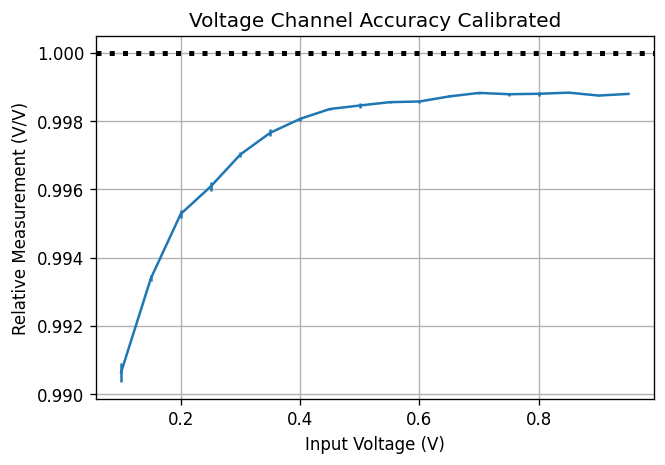

In [34]:
fig, ax = plot_accuracy(eval_data["V_in"], eval_data["V_fit"])

ax.set_title("Voltage Channel Accuracy Calibrated")
ax.set_xlabel("Input Voltage (V)")
ax.set_ylabel("Relative Measurement (V/V)")

Text(0, 0.5, 'Relative Measurement (A/A)')

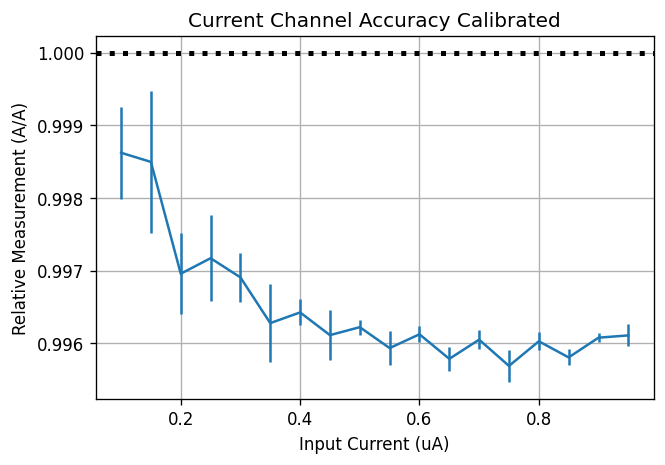

In [35]:
fig, ax = plot_accuracy(eval_data["I_in"], eval_data["I_fit"])

ax.set_title("Current Channel Accuracy Calibrated")
ax.set_xlabel("Input Current (uA)")
ax.set_ylabel("Relative Measurement (A/A)")